In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,93.853640,18.770728,21.756295,5
CCH Tax Forms Project,186.878946,8.898997,12.938888,21
Azure DevOps Pipelines,188.404692,94.202346,98.041175,2
OAuth 2.0 RFC6749,215.872756,19.624796,30.671027,11
pfSense,259.150967,21.595914,29.432520,12
Accounting,313.618726,18.448160,26.336115,17
Active Directory and Azure Files,335.114943,9.057161,20.768800,37
"The Starless Crown, Rollins",477.407710,17.681767,29.556943,27
Python + Oauth2.0,680.843889,29.601908,44.033319,23
Azure Files Documentation,899.906972,28.122093,51.239573,32


# Histogram

sum of ages: ~54831.15


<Axes: >

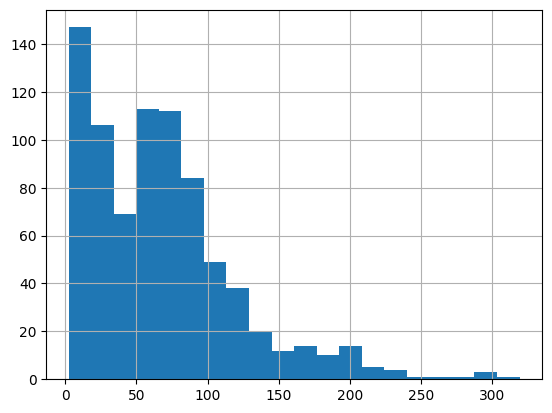

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54831.15


<Axes: >

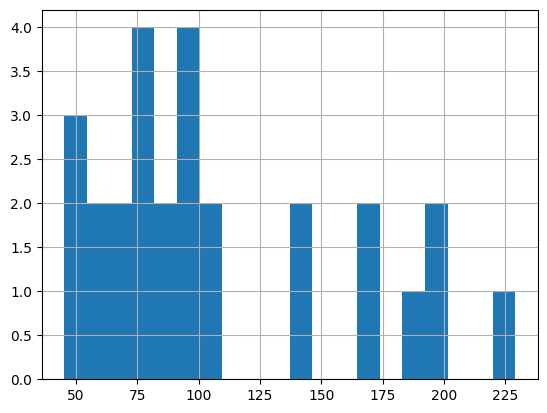

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 804
Total card age: 54831.15


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
12,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,319.410746,110.857936,-319.410746,1995.442846,0.503360,18,0,0,-319.410746
561,FSLogix,FSLogix Application Masking:\nA component of F...,d0fddc21b0997167e4a59d514b6934e6,144.107635,110.857936,-319.410746,1995.442846,0.503360,18,3,0,-144.107635
14,FSLogix,Cloud Cache uses the locally mounted container...,395fe6c9edfadeac3e8be549b66ded66,106.533279,110.857936,-319.410746,1995.442846,0.503360,18,6,0,-106.533279
15,FSLogix,Cloud Cache uses storage providers based on th...,44842f401f56251a420f6eaae9b5b151,93.982720,110.857936,-319.410746,1995.442846,0.503360,18,9,0,-93.982720
16,FSLogix,Remote Desktop Services (RDS):\nA session-base...,a680c7dea0aa2f9c75b74b3a331d1858,67.425541,110.857936,-319.410746,1995.442846,0.503360,18,12,0,-67.425541
17,FSLogix,When the local cache doesn't contain the data ...,29cc89097e63aa45cd021054050932e2,63.589463,110.857936,-319.410746,1995.442846,0.503360,18,15,0,-63.589463
66,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,302.152249,102.267136,-302.152249,5011.089683,0.976393,49,0,0,-302.152249
67,Vocab,"How to Sell a Haunted House, Hendrix\nTrimalle...",1cbfd950893772c1d42e4c3defaea154,193.353199,102.267136,-302.152249,5011.089683,0.976393,49,3,0,-193.353199
68,Vocab,"Something Rotten, Fforde\nBête noire\nnoun | B...",bd41707687e30dd135ecca740efd2fa8,158.120030,102.267136,-302.152249,5011.089683,0.976393,49,6,0,-158.120030
614,Vocab,"Something Rotten, Fforde\nThylacine\nnoun | TH...",755d01fe4fbce3e79bc958b29f734803,132.851409,102.267136,-302.152249,5011.089683,0.976393,49,9,0,-132.851409


## Card Count

In [11]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1581.5262711957)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
12,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,319.410746,110.857936,-319.410746,1995.442846,0.503360,18,0,0,-319.410746
66,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,302.152249,102.267136,-302.152249,5011.089683,0.976393,49,0,0,-302.152249
132,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,299.968514,64.718603,-299.968514,4983.332412,0.817380,77,0,0,-299.968514
18,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,299.267204,110.249167,-299.267204,3086.976662,0.054693,28,0,0,-299.267204
36,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,272.052530,106.556652,-272.052530,4049.152791,0.223532,38,0,0,-272.052530
313,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,257.933358,106.556652,-272.052530,4049.152791,0.223532,38,1,1,-257.933358
296,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,255.307547,110.249167,-299.267204,3086.976662,0.054693,28,1,1,-255.307547
406,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,238.167933,64.718603,-299.968514,4983.332412,0.817380,77,1,1,-238.167933
3,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,236.686957,117.615030,-236.686957,1176.150301,0.501870,10,0,0,-236.686957
270,VMWare,ESXi Shell\n\nA command-line interface (CLI) u...,29e8247f5a2aa78b7ff2123ac06ccfee,228.946542,108.247462,-228.946542,2922.681485,0.259684,27,0,0,-228.946542


In [15]:
existing_cards['age'].mean()

np.float64(68.19795023765613)